### Import libraries

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import glob
import os
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from scipy.signal import butter, filtfilt
import altair as alt
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
import pywt
from scipy.stats import wilcoxon
import matplotlib.cm as cm
import numpy as np
from sklearn.utils import resample
import h5py
import pickle
import scipy.io

/home/sphsc/cse583/.blap/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### Figure settings

In [2]:
alt.data_transformers.disable_max_rows()
plt.rcParams['font.family'] = 'Ubuntu Sans'

In [3]:
import matplotlib.font_manager
print([f.name for f in matplotlib.font_manager.fontManager.ttflist])

['DejaVu Serif', 'STIXGeneral', 'DejaVu Sans', 'STIXSizeFiveSym', 'DejaVu Serif', 'DejaVu Serif', 'STIXSizeOneSym', 'STIXSizeFourSym', 'cmtt10', 'DejaVu Sans Mono', 'cmr10', 'DejaVu Sans', 'STIXSizeTwoSym', 'DejaVu Sans', 'cmb10', 'cmex10', 'DejaVu Sans', 'STIXNonUnicode', 'DejaVu Sans Mono', 'STIXSizeFourSym', 'STIXGeneral', 'STIXNonUnicode', 'cmss10', 'STIXGeneral', 'DejaVu Sans Display', 'STIXNonUnicode', 'DejaVu Serif', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'DejaVu Sans Mono', 'cmsy10', 'cmmi10', 'STIXSizeThreeSym', 'STIXSizeThreeSym', 'DejaVu Serif Display', 'STIXSizeOneSym', 'STIXGeneral', 'STIXNonUnicode', 'MathJax_Math', 'MathJax_WinChrome', 'MathJax_Size3', 'DejaVu Serif', 'DejaVu Sans Mono', 'cmr10', 'GLYPHICONS Halflings', 'cmex10', 'dsrom10', 'Ubuntu', 'Ubuntu Sans', 'MathJax_Size2', 'Ubuntu', 'Ubuntu', 'MathJax_Size1', 'MathJax_Typewriter', 'Ubuntu Mono', 'Ubuntu Mono', 'MathJax_Fraktur', 'MathJax_Fraktur', 'Ubuntu', 'MathJax_Main', 'wasy10', 'Ubuntu', 'MathJax_Math', 'Mat

### Definitions

In [4]:
def read_data(subjid):
    pattern = f"/mnt/c/Users/seaudlab/Documents/hydroC/data/*{subjid}*.mat"
    files = glob.glob(pattern)
    print(files)
    
    import os

    for file in files:
        print(f"\nChecking file: {file}")
        print(f"  Exists: {os.path.exists(file)}")
        print(f"  Is file: {os.path.isfile(file)}")
        print(f"  File size: {os.path.getsize(file) if os.path.exists(file) else 'N/A'} bytes")
    
    data = {} # Accumulator
    freq_amp_table = []
    
    # Everything below can go to separate function
    for file in files:
        current_filename = file
        try:
            f = h5py.File(current_filename, 'r')
        except OSError:
            print(f"Skipping {current_filename} - cannot read file")
            continue
                
        ex_data = f['ex']

        freq_by_amp = ex_data[:].shape
        num_tested_freqs = freq_by_amp[1]
        num_tested_amps = freq_by_amp[0]
            
        channel_keys = ['ch1','ch2','ch3','ch4']
        period_keys = ['prestim_sig','stimresp_sig','poststimresp_sig']

        for tested_freqs in range(num_tested_freqs):
            for tested_amps in range(num_tested_amps):
                
                obj = f[ex_data[tested_amps,tested_freqs]]
                if isinstance(obj, h5py.Group): # i.e., checks if the cell actually had a ex template populated or is just [] (no freq, amp, etc. assigned)
                    # Empty arrays in matlab are still seen as datasets, so the way to check if there is anything inside a combo
                    # Is by checking if there are references for the signals at all
                    obj = f[ex_data[tested_amps,tested_freqs]]['electrodes']['ch1']['signals']['stimresp_sig'][:]
                    if obj.dtype == object: # i.e., checks if the cell, which has a populated template, actually has any data in it
                        # It's a group, access the 'decision' dataset inside
                        decision_ref = f[ex_data[tested_amps,tested_freqs]]['decision']
                        decision = f[ex_data[tested_amps,tested_freqs]]['decision'][:]
                        
                        if len(decision.shape) > 0:
                            freq_ref = f[ex_data[tested_amps,tested_freqs]]['frequency']
                            amp_ref = f[ex_data[tested_amps,tested_freqs]]['amplitude']
                            freq = freq_ref[0][0]
                            amp = amp_ref[0][0]
                            
                            freq_amp_table.append([freq,amp])
                            
                            period_len_ref = f[ex_data[tested_amps,tested_freqs]]['electrodes']['ch1']['signals']['stimresp_sig']
                            actual_data = f[period_len_ref[0, 0]][:] #use the first reference address to get actual data
                            period_len = actual_data.shape[0]
                            
                            if (freq, amp) not in data:
                                data[freq, amp] = []

                            data[freq, amp].append({'filename': current_filename, 'decision': decision, 'period_len': period_len})
                            
                            for channel in channel_keys:
                                sig_ref = f[ex_data[tested_amps,tested_freqs]]['electrodes'][channel]['signals']['stimresp_sig']
                                num_batches = sig_ref.shape[0]
                                all_batches = []
                                
                                print(f" sig_ref shape {sig_ref.shape}")
                                for batch in range(num_batches):
                                    sig = []
                                    for period in period_keys:
                                        sig_ref = f[ex_data[tested_amps,tested_freqs]]['electrodes'][channel]['signals'][period]
                                        sig.append(f[sig_ref[batch][0]][:])
                                    current_batch_all_periods = np.concatenate(sig)
                                    all_batches.append(current_batch_all_periods)
                                    
                                    print(f"Channel: {channel}")
                                    print(f"  current_batch_all_periods shape: {current_batch_all_periods.shape}")
                                    print(f"  len(all_batches): {len(all_batches)}")
                                
                                print(f"  all_batches array shape: {np.array(all_batches).shape}")
                                # Squeeze out the batches in dataset (1 batch = a set of trials)
                                sig_len = current_batch_all_periods.shape[0]
                                data[freq, amp][-1][channel] = np.array(all_batches).T.transpose(0, 2, 1).reshape(-1, sig_len)
                    else:
                        print(f"{current_filename},{tested_freqs},{tested_amps}, does not have data inside")
                else:
                    print(f"{current_filename},{tested_freqs},{tested_amps}, does not have references")
        
    return data, freq_amp_table
# Check 11/20/2025

In [5]:
def define_basic_vars():
    fs = 22050
    latency = 2118
    channel_keys = ['ch1','ch2','ch3','ch4']
    period_keys = ['prestim','stimresp']
    metric_keys = ['mean','std']
    submetric_keys = ['doub_freq_mag','SNR']
    return fs, latency, channel_keys, period_keys, metric_keys, submetric_keys
# check 11/20/2025

In [6]:
def pickle_data(subjid):
    np.savez(f'{subjid}_data.npz',
    data=data,
    freq_amp_table=freq_amp_table,
    latency=latency,
    channel_keys=channel_keys)
# If need to keep this dataset in python friendly form

In [7]:
def load_data(subjid):
    # example 'hydrolagusColliei_8'
    loaded = np.load(f'/mnt/c/Users/seaudlab/Documents/hydroC/{subjid}_data.npz', allow_pickle=True) # Aoi
    #loaded = np.load(f'{subjid}_data.npz', allow_pickle=True)
    data = loaded['data']
    freq_amp_table = loaded['freq_amp_table']
    
    return data, freq_amp_table


In [8]:
def remove_artefacts(data):
    # Loop through each (freq, amp) key
    for coord, dataset_list in data.items():
        # Loop through each dataset in the list
        for dataset_idx, dictionary in enumerate(dataset_list):
            print(f"Processing coord {coord}, dataset {dataset_idx}")
            
            # Artifact removal for each channel
            for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
                print(dictionary[channel].shape)
                rms_per_row = np.sqrt(np.mean(dictionary[channel]**2, axis=1))
                print(f"{channel}: rms = {rms_per_row.shape}")
                rms_mean = np.mean(rms_per_row) # calculate mean rms across all trials
                rms_std = np.std(rms_per_row) # calculate std rms across all trials
                
                # See which rows has an rms that is too high (i.e., artifact) and remove them
                threshold = rms_mean + (rms_std*3)
                keep_rows = rms_per_row <= threshold
                dictionary[channel] = dictionary[channel][keep_rows]
                dictionary[f'{channel}_total_trials'] = dictionary[channel].shape[0]
            
            # Determine the minimum number of trials across all channels
            min_trials = min([dictionary[f'{channel}_total_trials'] for channel in ['ch1', 'ch2', 'ch3', 'ch4']])
            
            # Randomly select the same number of trials for each channel
            for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
                np.random.seed(42)
                
                # Get indices for the channel
                channel_indices = np.arange(dictionary[channel].shape[0])
                
                # Randomly select indices
                selected_indices = np.random.choice(channel_indices, size=min_trials, replace=False)
                
                # Update the channel data with selected trials
                dictionary[channel] = dictionary[channel][selected_indices]
                
                # Update the total trials count
                dictionary[f'{channel}_total_trials'] = min_trials
    
    return data

# Check 11/20/2025

In [9]:
def select_stimulus(data, myfreq, myamp, dataset_index):
    specific_key = (np.float64(myfreq), np.float64(myamp))
    all_datasets = data[specific_key]  # This is a list now
    
    print(f"Found {len(all_datasets)} dataset(s) for freq={myfreq}, amp={myamp}")
    print(f"Selecting dataset {dataset_index} from file: {all_datasets[dataset_index]['filename']}")
    
    return all_datasets[dataset_index]
# checked 11/20/2025

In [10]:
def bandpass(data, low, high, fs, order=4):
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype='band')
    return filtfilt(b, a, data, axis=1)

# check 11/20/2025
# For digital (as opposed to non-discretised analog) filters, if fs is not specified, 
# Wn units are normalized from 0 to 1,where 1 is the Nyquist frequency (Wn is thus in half-cycles / sample).

#### Analysis definitions

In [11]:
def add_weights(data, channel_keys, weights):
    weighted_data = {}
    for idx, channel in enumerate(channel_keys):
        current_data = data[channel]
        current_weight = weights[idx]
        weighted_data[channel] = current_data * current_weight
    return weighted_data

In [12]:
def separate_periods(data, current_cond, period_keys, channel_keys, latency):
    separated_data = {
        'prestim': {},
        'stimresp': {}
    }
    
    period_len = current_cond['period_len']
    
    for period in period_keys:
        for channel in channel_keys:            
            if period == 'prestim':
                separated_data[period][channel] = data[channel][:,latency:latency+period_len]     
            elif period == 'stimresp':
                separated_data[period][channel] = data[channel][:,latency+period_len:latency+period_len*2]
                
    return separated_data
# check 11/20/25 latency is what i need to shift the slicing by see obsidian note "Latency issue 8-26-25"
# confimed that the two period slices do not overlap with one another

In [13]:
def compute_fft(data, channel_keys, period_keys,smallest_dim, fs):
    # No channels or periods
    if len(period_keys) == 0 and len(channel_keys) == 0:
        fft_magnitudes = {}
        fft_freq_vecs = {}
        
        trial_magnitudes = []
        freq_vecs = []
        
        if smallest_dim == 1:
            num_cols = data.shape[smallest_dim]
            for trial in range(num_cols):
                cur_trial = data[:,trial]
                n_samples = len(cur_trial)
                # Calculate frequencies for positive frequencies only
                freqs = np.fft.rfftfreq(fs, d=1/fs) # fs= window length, d = sampling period
                
                # Calculate magnitude spectrum
                fft_vals = np.fft.rfft(cur_trial,n=fs) # cur_trial= data to do, fs = zero pad up to the fs
                magnitude = np.abs(fft_vals)/n_samples # divide by the number of samples to recover magntiude values                
                trial_magnitudes.append(magnitude)
                freq_vecs.append(freqs)
                    
                fft_magnitudes = np.vstack(trial_magnitudes)
                fft_freq_vecs = np.vstack(freq_vecs)
    
    # Only have channels        
    elif len(period_keys) == 0 and len(channel_keys) > 0:
        # Initialize dictionaries with nested structure
        fft_magnitudes = {}
        fft_freq_vecs = {}
        
        for channel in channel_keys:
            trial_magnitudes = []
            freq_vecs = []
            num_trial = min(data[channel].shape)
            for trial in range(num_trial):
                cur_trial = data[channel][trial]
                n_samples = len(cur_trial)
                # Calculate frequencies for positive frequencies only
                freqs = np.fft.rfftfreq(fs, d=1/fs)
                
                # Calculate magnitude spectrum
                fft_vals = np.fft.rfft(cur_trial,n=fs)
                magnitude = np.abs(fft_vals)/n_samples
                
                trial_magnitudes.append(magnitude)
                freq_vecs.append(freqs)
                
            fft_magnitudes[channel] = np.vstack(trial_magnitudes)
            fft_freq_vecs[channel] = np.vstack(freq_vecs)
    
    # Have both period and channel delination
    elif len(period_keys) > 0 and len(channel_keys) > 0: 
        # Initialize dictionaries with nested structure
        fft_magnitudes = {period: {} for period in period_keys}
        fft_freq_vecs = {period: {} for period in period_keys}
        
        for period in period_keys:
            for channel in channel_keys:
                trial_magnitudes = []
                freq_vecs = []
                num_trial = data[period][channel].shape[0]
                
                for trial in range(num_trial):
                    cur_trial = data[period][channel][trial]
                    n_samples = len(cur_trial)
                    # Calculate frequencies for positive frequencies only
                    freqs = np.fft.rfftfreq(fs, d=1/fs)
                    
                    # Calculate magnitude spectrum
                    fft_vals = np.fft.rfft(cur_trial,n=fs)
                    magnitude = np.abs(fft_vals)/n_samples
                    
                    trial_magnitudes.append(magnitude)
                    freq_vecs.append(freqs)
                    
                fft_magnitudes[period][channel] = np.vstack(trial_magnitudes)
                fft_freq_vecs[period][channel] = np.vstack(freq_vecs)
    
    # Return both dictionaries
    return fft_magnitudes, fft_freq_vecs
# Check 11/20/2025

In [14]:
def find_large_stds(data, freq_vecs, period_keys, channel_keys, metric_keys, myfreq):
    my_rat_data = {}
    my_SNR_data = {}
    target_freq = myfreq*2
    for channel in channel_keys.copy():
        my_rat_data[channel] = []
        cur_avg = data['average']['stimresp'][channel]
        print(len(cur_avg))
        cur_std = data['std']['stimresp'][channel]
        cur_freq_vec = freq_vecs['stimresp'][channel][0]
        
        # Double frequency mask (3 Hz tolerance)
        doub_mask = np.abs(cur_freq_vec - target_freq) <= 3
        my_mean = cur_avg[doub_mask]
        my_std = cur_std[doub_mask]
        my_rat = my_std/my_mean
        my_rat_data[channel].append(my_rat)
        
        print(f"{channel} : {my_rat}")
    
        if my_rat > 6:
            print(f"Warning {channel} has super high std value")
            
    filt_channel_keys = channel_keys

    return my_rat_data, filt_channel_keys

### ICA related defs

In [15]:
def reshape_the_data(data, channel_keys, period_keys, bootstrapped=False):
    # Reshape to (trials * samples) x channels
    reshaped_list = []
    for channel in channel_keys:
        cur_set = data[channel]
        reshaped_list.append(cur_set.reshape(-1, 1))
    
    reshaped_data = np.hstack(reshaped_list)
    return reshaped_data

# check 11/20/2025
# X = array-like of shape (n_samples, n_features)

In [16]:
def perform_ICA(data, channel_keys):
    start = time.perf_counter()
    
    # Standardize the data
    # Removes the mean and sets variance across ICs to 1, necessary for ICA to work
    # Standardization of a dataset is a common requirement for many machine learning estimators: 
    # they might behave badly if the individual features do not
    # more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Improved FastICA configuration
    # Use default variables more or less except max_iter set to 500 instead of 200
    ica = FastICA(
        n_components=len(channel_keys), 
        random_state=42,  # More robust random seed
        max_iter=500,     # Increased iterations
        tol=1e-4,         # Tightened tolerance???
        whiten='unit-variance'  # Corrected whiten parameter
    )
    
    S = ica.fit_transform(data_scaled)
    A = ica.mixing_

    end = time.perf_counter()
    elasped = end - start
    
    # Convergence check
    print(f"Elapsed time: {elasped:.2f} seconds")
    print(f"ICA Convergence: {ica.n_iter_}")
    
    # Store results in dictionary
    ica_results = {
        'S': S,
        'A': A,
        'n_iter': ica.n_iter_,
        'elapsed_time': elasped
    }
    
    return ica_results

# check 11/20/2025

In [17]:
def calculate_diff_CI(data, submetric):
    prestim = data['prestim'][submetric]
    stimresp = data['stimresp'][submetric]
    diff = stimresp - prestim

    # 2. Compute 95% confidence interval for the difference (non-parametric confidence interaval)
    lower = float(np.percentile(diff, 2.5))
    upper = float(np.percentile(diff, 97.5))

    print("95% CI:", (lower, upper))

    # 3. Decision rule: if CI excludes 0 → significant
    if lower > 0 or upper < 0:
        print("Groups differ significantly (CI excludes 0).")
    else:
        print("No significant difference (CI includes 0).")
    
    return [lower, upper]
# Check 11/20/25
# source for why you cannot do t-tests/etc. on bootstrapped distributions
# https://www.stat.umn.edu/geyer/5601/examp/tests.html?utm_source=chatgpt.com
# If 0 is included in 95% CI then diff of 0 is a plausible value for the true difference

In [18]:
def select_doub_freq_bin(data, frequencies, period_keys, myfreq, window_size=100):
    if len(period_keys) == 0:
        doub_freq_dict = {}
        
        target_freq = 2*myfreq
        part_window = window_size/2
        artifact_freqs = [myfreq, target_freq, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900]
        freq_vec = frequencies[0]
            
        # Double frequency mask (3 Hz tolerance)
        doub_mask = np.abs(freq_vec - target_freq) <= 3
        print(doub_mask.shape)
        print(freq_vec[doub_mask])
        window_mask = (freq_vec >= target_freq-part_window) & (freq_vec <= target_freq+part_window)
        print(freq_vec[window_mask])
        
        for freq in artifact_freqs:
            art_mask = np.abs(freq_vec - freq) <= 3
            window_mask[art_mask] = False
        print(freq_vec[window_mask])
            
        num_it = data.shape[0]

        doub_freq_tmp = []
        snr_tmp = []
        
        for cur_it in range(num_it):
            cur_data = data[cur_it]
            doub_mag = cur_data[doub_mask]
            remain_mag = cur_data[window_mask]
            
            doub_mag = np.mean(doub_mag)
            remain_mag = np.mean(remain_mag)
            
            doub_freq_tmp.append(doub_mag)
            snr_tmp.append(10 * np.log10((doub_mag) / (remain_mag)))
            
        # Move this inside the period loop
        doub_freq_dict = {
            'doub_freq_mag': np.hstack(doub_freq_tmp),
            'SNR': np.hstack(snr_tmp)
        }
        
    elif len(period_keys) > 0:
        doub_freq_dict = {
            'prestim': {},
            'stimresp': {}
        }
            
        target_freq = 2*myfreq
        part_window = window_size/2
        artifact_freqs = [myfreq, target_freq, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900]
        freq_vec = frequencies['prestim']['ch1']
        # Double frequency mask (3 Hz tolerance)
        doub_mask = np.abs(freq_vec - target_freq) <= 3
        window_mask = (freq_vec >= target_freq-part_window) & (freq_vec <= target_freq+part_window)
        print(window_mask.shape)
        
        for freq in artifact_freqs:
            art_mask = np.abs(freq_vec - freq) <= 3
            window_mask[art_mask] = False
            
        num_it = len(data['prestim'])
        doub_mask = doub_mask[0] # I am doing this since freq_vec is a matrix? check this...
        print(freq_vec[0][doub_mask])
        window_mask = window_mask[0]
        print(window_mask.shape)
        print(freq_vec[0][window_mask])
        
        print(num_it)
        
        for period in period_keys:
            doub_freq_tmp = []
            snr_tmp = []
            for cur_it in range(num_it):
                cur_data = data[period][cur_it]
                doub_mag = cur_data[doub_mask]
                remain_mag = cur_data[window_mask]
                
                doub_mag = np.mean(doub_mag)
                remain_mag = np.mean(remain_mag)
                
                doub_freq_tmp.append(doub_mag)
                snr_tmp.append(10 * np.log10((doub_mag) / (remain_mag)))
            
            # Move this inside the period loop
            doub_freq_dict[period] = {
                'doub_freq_mag': np.hstack(doub_freq_tmp),
                'SNR': np.hstack(snr_tmp)
            }
            
    return doub_freq_dict
# check 11/20/25

In [19]:
def create_ICA_weights(data):
    # doub_freq_ICA = data
    weights = []
    snr_db = data['SNR']
    linear_snr = 10**(snr_db/10) # take the inverse log to calculate linear_snr
    weights = linear_snr / linear_snr.sum() # normalize by the sum of the snrs
    
    return weights
# check 11/20/25

In [20]:
def weight_and_reconstruct_ica(ica_results, current_cond, channel_keys, components_to_keep, component_weights=None):
    recon_restruct_data = {}
    
    # Extract ICA results
    S = ica_results['S']
    A = ica_results['A']
    
    # Create a weighted reconstruction
    if component_weights is None:
        # If no weights provided, use default (keeping all selected components equally)
        component_weights = np.ones(len(components_to_keep))
    
    # Ensure weights match the number of components to keep
    assert len(component_weights) == len(components_to_keep), "Number of weights must match number of components"
    
    # Filter independent components
    S_filtered = S[:, components_to_keep]
    A_filtered = A[:, components_to_keep]
    
    # Apply weights to the independent components
    S_weighted = S_filtered * component_weights
    
    # Reconstruct the data with weighted components
    # np.dot = Multiply rows of left matrix with columns of right matrix and sums the products
    reconstructed_data = np.dot(S_weighted, A_filtered.T) # Matrix multiplication of the two matrices to get signals back
    
    n_trials = current_cond['ch1'].shape[0]
    n_samples_per_trial = current_cond['ch1'].shape[1]
    
    for idx, channel in enumerate(channel_keys):
        recon_restruct_data[channel] = reconstructed_data[:, idx].reshape(n_trials, n_samples_per_trial)  
    
    return recon_restruct_data
# check 11/20/25

In [21]:
def compare_denoised_waveform(filt_data, recon_restruct_data, channel_keys, myfreq, myamp, subjid, fs, dataset_index, fft_ylim=None):
    data_type = ['original','denoised']
    # Calculate grand mean
    compare_denoising_mean = {
        'original': {channel: np.mean(filt_data[channel], axis=0) for channel in channel_keys},
        'denoised': {channel: np.mean(recon_restruct_data[channel], axis=0) for channel in channel_keys}
    }

    compare_denoising_std = {
        'original': {channel: np.std(filt_data[channel], axis=0) for channel in channel_keys},
        'denoised': {channel: np.std(recon_restruct_data[channel], axis=0) for channel in channel_keys}
    }
    
    # Calculate ffts
    fft_magnitudes_mean = {
        'original': {},
        'denoised': {}
    }
    
    fft_magnitudes_std = {
        'original': {},
        'denoised': {}
    }
    
    fft_freq_vecs = {
        'original': {},
        'denoised': {}
    }
    
    for dtype in data_type:
        for channel in channel_keys:
            cur_mag_mean = compare_denoising_mean[dtype][channel]
            cur_mag_std = compare_denoising_std[dtype][channel]
            n_samples = len(cur_mag_mean)
            
            # Frequency vector
            freqs = np.fft.rfftfreq(fs, d=1/fs)
            fft_freq_vecs[dtype][channel] = freqs
            
            # Mean
            fft_vals = np.fft.rfft(cur_mag_mean, n=fs)
            magnitude = np.abs(fft_vals)/n_samples
            fft_magnitudes_mean[dtype][channel] = magnitude
            
            # STD
            fft_vals = np.fft.rfft(cur_mag_std,n=fs)
            magnitude = np.abs(fft_vals)/n_samples
            fft_magnitudes_std[dtype][channel] = magnitude
        
    # Waveform plot
    n_channels = len(channel_keys)
    fig, axes = plt.subplots(n_channels, 2, figsize=(12, 3*n_channels), sharex=True, sharey=True)

    for i, channel in enumerate(channel_keys):
        # Left column: Original
        ax_orig = axes[i, 0] if n_channels > 1 else axes[0]
        mean_orig = compare_denoising_mean['original'][channel]
        std_orig = compare_denoising_std['original'][channel]
        
        ax_orig.plot(mean_orig, label='Mean', color='#5778a4')
        ax_orig.fill_between(range(len(mean_orig)), 
                            mean_orig - std_orig, 
                            mean_orig + std_orig, 
                            alpha=0.3, color='#5778a4')
        ax_orig.set_title(f'{channel} - Original')
        ax_orig.set_ylabel('Value')
        if i == n_channels - 1:
            ax_orig.set_xlabel('Time/Sample')
        
        # Right column: Denoised
        ax_denoise = axes[i, 1] if n_channels > 1 else axes[1]
        mean_denoise = compare_denoising_mean['denoised'][channel]
        std_denoise = compare_denoising_std['denoised'][channel]
        
        ax_denoise.plot(mean_denoise, label='Mean', color='#e49444')
        ax_denoise.fill_between(range(len(mean_denoise)), 
                                mean_denoise - std_denoise, 
                                mean_denoise + std_denoise, 
                                alpha=0.3, color='#e49444')
        ax_denoise.set_title(f'{channel} - Denoised')
        ax_denoise.set_ylabel('Value')
        if i == n_channels - 1:
            ax_denoise.set_xlabel('Time/Sample')

    plt.tight_layout()
    plt.savefig(f"plots/{subjid}/{subjid}_{myfreq}Hz_{myamp}dB_compare_ICA_denoised_waveform_{dataset_index}.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=600)
    plt.show()
    
    # FFT plot
    n_data_types = len(data_type)
    fig, axes = plt.subplots(n_channels, n_data_types, figsize=(6*n_data_types, 4*n_channels),sharex=True,sharey=True)

    # Handle case where axes might not be 2D array
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    if n_data_types == 1:
        axes = axes.reshape(-1, 1)

    # Plot each combination
    for i, channel in enumerate(channel_keys):
        for j, dtype in enumerate(data_type):
            ax = axes[i, j]
            
            # Get data for this channel and data type
            freqs = fft_freq_vecs[dtype][channel]
            mean_mag = fft_magnitudes_mean[dtype][channel]
            std_mag = fft_magnitudes_std[dtype][channel]
            
            # Plot mean line
            if dtype == 'original':
                ax.plot(freqs, mean_mag, linewidth=2,color='#5778a4', label='Mean')
                
            if dtype == 'denoised':
                ax.plot(freqs, mean_mag, linewidth=2,color='#e49444', label='Mean')
            
            # Plot shaded std area
            if dtype == 'original':
                ax.fill_between(freqs, 
                                mean_mag - std_mag, 
                                mean_mag + std_mag, 
                                alpha=0.3,
                                color='#5778a4',
                                label='±1 SD')
            
            if dtype == 'denoised':
                ax.fill_between(freqs, 
                                mean_mag - std_mag, 
                                mean_mag + std_mag, 
                                alpha=0.3,
                                color='#e49444',
                                label='±1 SD')
            
            # Labels
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Magnitude')
            ax.set_title(f'{channel} - {dtype}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_ylim(fft_ylim)
            ax.set_xlim([(myfreq*2-100), (myfreq*2+100)])
            ax.axvline(x=myfreq*2, color='r', linestyle='--', linewidth=.5)
            
    plt.tight_layout()
    # Save figure
    plt.savefig(f"plots/{subjid}/{subjid}_{myfreq}Hz_{myamp}dB_compare_ICA_denoised_fft_{dataset_index}.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=600)
    plt.show()
    
    return compare_denoising_mean, compare_denoising_std, fft_magnitudes_mean, fft_magnitudes_std, fft_freq_vecs
# check 11/20/2025

### Bootstrapped related

In [22]:
def collapse_channels(data, period_keys, channel_keys):
    collapsed_dict = {
        'prestim': None,
        'stimresp': None
    }
    for period in period_keys:
        tmp = []
        for channel in channel_keys:
            tmp.append(data[period][channel])
        collapsed_dict[period] = np.vstack(tmp)
        
    return collapsed_dict
# check 11/20/25

In [23]:
def calculate_bootstrap(data, period_keys, channel_keys, n_iterations, random_state=42):
    # Ensure consistent random sampling across iterations
    rng = np.random.default_rng(random_state) # create a standalone random number generator object
    # Determine the maximum number of samples across periods
    max_samples = max(len(data[period]) for period in period_keys)
    print(max_samples)

    boot_means = {period: [] for period in period_keys}
    boot_std = {period: [] for period in period_keys}

    for _ in range(n_iterations):
        # Generate a single set of indices to use for all periods (i.e., paired bootstrap)
        sample_indices = rng.choice(max_samples, size=max_samples, replace=True)

        for period in period_keys:
            cur_data = data[period]

            # Resample using the same indices for each period
            resampled_data = cur_data[sample_indices]

            boot_means[period].append(np.mean(resampled_data, axis=0))
            boot_std[period].append(np.std(resampled_data, axis=0))

    
    return boot_means, boot_std
# check 11/20/25

#### Plotting definitions

In [24]:
def plot_waveforms(data, channel_keys, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25):
    if len(channel_keys) == 0:
        num_row = data.shape[1]
        fig, axes = plt.subplots(num_row, 1, figsize=figsize, sharex=True, sharey=True)

        for row_idx in range(num_row):
            ax = axes[row_idx]
            current_data = data[:,row_idx]
            ax.plot(current_data, alpha=alpha)
            
    else:
        fig, axes = plt.subplots(len(channel_keys), 1, figsize=figsize, sharex=True, sharey=True)
        
        if len(channel_keys) == 1:
            axes = [axes]
        
        for row_idx, channel in enumerate(channel_keys):
            ax = axes[row_idx]
            current_data = data[channel]
            
            random_indices = np.random.choice(current_data.shape[0], 
                                            size=min(num_samples, current_data.shape[0]), 
                                            replace=False)
            
            for i in random_indices:
                ax.plot(current_data[i, :], alpha=alpha)
            
            ax.set_ylabel(channel)
    
    fig.suptitle(title)
    fig.tight_layout()
    
    return fig, axes
# Checked 11/20/25

In [25]:
def plot_fft(magnitudes, frequencies, myfreq, myamp, subjid,  dataset_index, channel_keys, period_keys=None, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25,xlim=[],ylim=[]):
    if len(channel_keys) == 0:      
        fig, axes = plt.subplots(len(magnitudes), 1, figsize=figsize, sharex=True, sharey=True)
        for row_idx in range(len(magnitudes)):
            ax = axes[row_idx]
            cur_mag = magnitudes[row_idx]
            cur_freq = frequencies[row_idx]
            ax.plot(cur_freq,cur_mag, alpha=alpha)
            
            ax.set_ylabel(str(row_idx))
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.axvline(x=myfreq*2, color='red', linestyle='--', linewidth=.5, label='threshold')
            
    elif len(channel_keys) > 1 and len(period_keys) == 0:
        fig, axes = plt.subplots(len(channel_keys), 1, figsize=figsize, sharex=True, sharey=True)
        for row_idx, channel in enumerate(channel_keys):
            ax = axes[row_idx]
            cur_mag = magnitudes[channel]
            cur_freq = frequencies[channel]
            
            random_indices = np.random.choice(cur_mag.shape[0], 
                                            size=min(num_samples, cur_mag.shape[0]), 
                                            replace=False)
            
            for i in random_indices:
                ax.plot(cur_freq[i, :],cur_mag[i, :], alpha=alpha)
            
            ax.set_ylabel(channel)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.axvline(x=myfreq*2, color='red', linestyle='--', linewidth=.5, label='threshold')
            
    elif len(channel_keys) > 0 and len(period_keys) > 0:
        fig, axes = plt.subplots(len(channel_keys), len(period_keys), figsize=figsize, sharex=True, sharey=True)
        
        for col_idx, period in enumerate(period_keys):
            for row_idx, channel in enumerate(channel_keys):
                ax = axes[row_idx,col_idx]
                cur_mag = magnitudes[period][channel]
                cur_freq = frequencies[period][channel]
                
                random_indices = np.random.choice(cur_mag.shape[0], 
                                                size=min(num_samples, cur_mag.shape[0]), 
                                                replace=False)
                
                for i in random_indices:
                    ax.plot(cur_freq[i, :],cur_mag[i, :], alpha=alpha)
                
                ax.set_ylabel(channel)
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.axvline(x=myfreq*2, color='red', linestyle='--', linewidth=.5, label='threshold')
    
    
    fig.suptitle(f"{subjid} {myfreq} Hz {myamp} dB: {title}")
    fig.tight_layout()
    plt.savefig(f"plots/{subjid}/{subjid}_{myfreq}Hz_{myamp}dB_{title}_{dataset_index}.png", 
        format='png', 
        bbox_inches='tight', 
        dpi=600)
    return fig, axes
# check 11/20/2025

In [26]:
def plot_doub_freq_hist(doub_freq_dict, subjid, submetric, myfreq, myamp, bin_num, dataset_index):
    # Create the figure 
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot histograms for both periods
    ax.hist(doub_freq_dict['prestim'][submetric], 
            bins=bin_num, 
            alpha=0.6,
            color = '#5778a4')
    ax.hist(doub_freq_dict['stimresp'][submetric], 
            bins=bin_num, 
            alpha=0.6,
            color = '#e49444')
    
    ax.set_title(f"{subjid} {myfreq}Hz {myamp}dB", fontsize=18)
    ax.set_xlabel('AEP Response Relative Magnitude', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    # ax.legend(fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f"plots/{subjid}/{subjid}_{myfreq}Hz_{myamp}dB_2x_resp_hist_magnitude_{dataset_index}.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=600)
    
    # Show the plot and keep it open
    plt.show()
    # Check 11/20/25

In [27]:
def plot_bootstrap_fft_comparison(mean_fft_prestim, std_fft_prestim, 
                        mean_fft_stimresp, std_fft_stimresp, 
                        freq_vec, myfreq, myamp, subjid, dataset_index, xlim=None, ylim=None,
                        save_fig=False, save_path=None):
    
    # Create figure with shared axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), 
                                    sharex=True, sharey=True)
    
    # Plot prestim FFT
    ax1.plot(freq_vec, mean_fft_prestim, '-',color='#5778a4', label='Mean FFT')
    ax1.fill_between(freq_vec, 
                      mean_fft_prestim - std_fft_prestim,
                      mean_fft_prestim + std_fft_prestim,
                      alpha=0.3, color='#5778a4', label='±1 STD')
    
    # Add vertical line at 2nd harmonic
    ax1.axvline(myfreq*2, color='red', linestyle='--', 
                linewidth = 0.5, alpha=0.7)
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Magnitude')
    ax1.set_title('Stim OFF')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot stimresp FFT
    ax2.plot(freq_vec, mean_fft_stimresp, '-', color='#e49444',label='Mean FFT')
    ax2.fill_between(freq_vec,
                      mean_fft_stimresp - std_fft_stimresp,
                      mean_fft_stimresp + std_fft_stimresp,
                      alpha=0.3, color='#e49444', label='±1 STD')
    
    # Add vertical line at 2nd harmonic
    ax2.axvline(myfreq*2, color='red', linestyle='--', 
                linewidth = 0.5, alpha=0.7)
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_title('Stim ON')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Set x limits if provided
    if xlim is not None:
        ax1.set_xlim(xlim)
        
    if ylim is not None:
        ax1.set_ylim(ylim)
    
    plt.tight_layout()
    
    # Save figure if requested
    if save_fig:
        filename = f"plots/{subjid}/{subjid}_{myfreq}Hz_{myamp}dB_grand_avg_comparison_{dataset_index}.png"
        if save_path:
            import os
            filename = os.path.join(save_path, filename)
        plt.savefig(filename, dpi=600, bbox_inches='tight')
    
    plt.show()
# check 11/20/25

### Load data

#### Unpickled

In [554]:
subjid = 'hydrolagusColliei_4'
data, freq_amp_table = read_data(subjid)
fs, latency, channel_keys, period_keys, metric_keys, submetric_keys = define_basic_vars()

['/mnt/c/Users/seaudlab/Documents/hydroC/data/hydrolagusColliei_4_AdaptiveAEP_Ratfish_2506192030_1_run.mat', '/mnt/c/Users/seaudlab/Documents/hydroC/data/hydrolagusColliei_4_AdaptiveAEP_Ratfish_2506192216_1_run_ThresholdsExcept330.mat', '/mnt/c/Users/seaudlab/Documents/hydroC/data/hydrolagusColliei_4_AdaptiveAEP_Ratfish_2506192237_1_run_330Hz_thresholds.mat', '/mnt/c/Users/seaudlab/Documents/hydroC/data/hydrolagusColliei_4_AdaptiveAEP_Ratfish_250619_2037_1_run.mat', '/mnt/c/Users/seaudlab/Documents/hydroC/data/hydrolagusColliei_4_AdaptiveAEP_Ratfish_250619_2051_run1.mat']

Checking file: /mnt/c/Users/seaudlab/Documents/hydroC/data/hydrolagusColliei_4_AdaptiveAEP_Ratfish_2506192030_1_run.mat
  Exists: True
  Is file: True
  File size: 30323254 bytes

Checking file: /mnt/c/Users/seaudlab/Documents/hydroC/data/hydrolagusColliei_4_AdaptiveAEP_Ratfish_2506192216_1_run_ThresholdsExcept330.mat
  Exists: True
  Is file: True
  File size: 2878829295 bytes

Checking file: /mnt/c/Users/seaudlab/D

#### Pickled

In [555]:
# subjid = 'hydrolagusColliei_8'
# data, freq_amp_table, latency, channel_keys, period_keys, metric_keys, submetric_keys = load_data(subjid)

### What stim combos do we have?

In [556]:
freq_amp_table_df = pd.DataFrame(freq_amp_table).sort_values(by= [0,1],ascending=True)
freq_amp_table_df

,0,1
4,55.0,110.0
34,55.0,110.0
37,55.0,110.0
3,55.0,115.0
33,55.0,115.0
36,55.0,115.0
2,55.0,120.0
32,55.0,120.0
35,55.0,120.0
1,55.0,125.0


### Data cleaning

In [557]:
cleaned_data = remove_artefacts(data)

Processing coord (np.float64(55.0), np.float64(130.0)), dataset 0
(20, 10584)
ch1: rms = (20,)
(20, 10584)
ch2: rms = (20,)
(20, 10584)
ch3: rms = (20,)
(20, 10584)
ch4: rms = (20,)
Processing coord (np.float64(55.0), np.float64(125.0)), dataset 0
(20, 10584)
ch1: rms = (20,)
(20, 10584)
ch2: rms = (20,)
(20, 10584)
ch3: rms = (20,)
(20, 10584)
ch4: rms = (20,)
Processing coord (np.float64(55.0), np.float64(120.0)), dataset 0
(140, 10584)
ch1: rms = (140,)


(140, 10584)
ch2: rms = (140,)
(140, 10584)
ch3: rms = (140,)
(140, 10584)
ch4: rms = (140,)
Processing coord (np.float64(55.0), np.float64(120.0)), dataset 1
(80, 10584)
ch1: rms = (80,)
(80, 10584)
ch2: rms = (80,)
(80, 10584)
ch3: rms = (80,)
(80, 10584)
ch4: rms = (80,)
Processing coord (np.float64(55.0), np.float64(120.0)), dataset 2
(100, 10584)
ch1: rms = (100,)
(100, 10584)
ch2: rms = (100,)
(100, 10584)
ch3: rms = (100,)
(100, 10584)
ch4: rms = (100,)
Processing coord (np.float64(55.0), np.float64(115.0)), dataset 0
(600, 10584)
ch1: rms = (600,)
(600, 10584)
ch2: rms = (600,)
(600, 10584)
ch3: rms = (600,)
(600, 10584)
ch4: rms = (600,)
Processing coord (np.float64(55.0), np.float64(115.0)), dataset 1
(300, 10584)
ch1: rms = (300,)
(300, 10584)
ch2: rms = (300,)
(300, 10584)
ch3: rms = (300,)
(300, 10584)
ch4: rms = (300,)
Processing coord (np.float64(55.0), np.float64(115.0)), dataset 2
(140, 10584)
ch1: rms = (140,)
(140, 10584)
ch2: rms = (140,)
(140, 10584)
ch3: rms = (14

### Select stimulus

Found 1 dataset(s) for freq=360, amp=135
Selecting dataset 0 from file: /mnt/c/Users/seaudlab/Documents/hydroC/data/hydrolagusColliei_4_AdaptiveAEP_Ratfish_2506192216_1_run_ThresholdsExcept330.mat
(492, 10584)


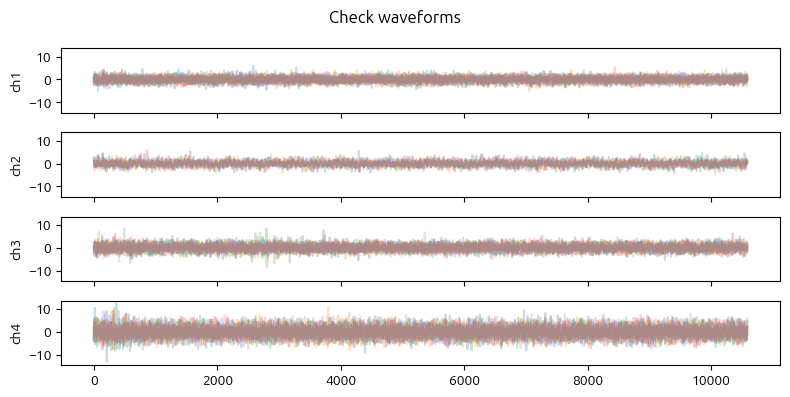

In [1209]:
# Select stimulus
myfreq = 360
myamp = 135
dataset_index = 0
current_cond = select_stimulus(cleaned_data, myfreq, myamp, dataset_index)
plot_waveforms(current_cond, channel_keys, title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25)
print(current_cond['ch1'].shape)

### Bandpass filter

In [1210]:
low, high = 70, 1400 # Getting rid of junk thats all it is! Don't center on the double frequency response, filtering = bias, base on auditory range, don't introduce that I know what to expect for this given stimulus frequency
filt_data = {}
for channel in channel_keys:
    tmp = []
    cur_data = current_cond[channel]
    tmp.append(bandpass(cur_data, low, high, fs))
    filt_data[channel] = np.hstack(tmp)

(<Figure size 800x400 with 4 Axes>,
 array([<Axes: ylabel='ch1'>, <Axes: ylabel='ch2'>, <Axes: ylabel='ch3'>,
        <Axes: ylabel='ch4'>], dtype=object))

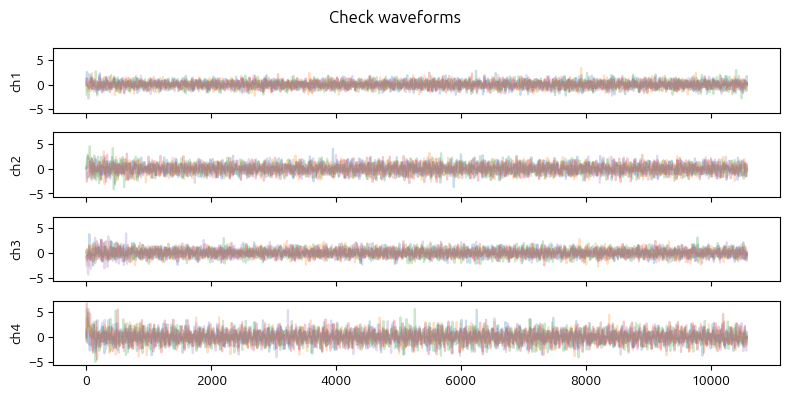

In [1211]:
plot_waveforms(filt_data, channel_keys, 
               title='Check waveforms', num_samples=5, figsize=(8, 4), alpha=0.25)

### ICA

In [1212]:
reshaped_data = reshape_the_data(filt_data, channel_keys, period_keys)
#reshaped_data = reshape_the_data(current_cond, channel_keys, period_keys)
ica_results = perform_ICA(reshaped_data, channel_keys)
input_data = ica_results['S']
ica_fft_magnitudes, ica_fft_freq_vec = compute_fft(
    input_data, channel_keys=[], period_keys=[], smallest_dim = 1, fs=fs)


Elapsed time: 6.94 seconds
ICA Convergence: 6


(<Figure size 800x400 with 4 Axes>,
 array([<Axes: ylabel='0'>, <Axes: ylabel='1'>, <Axes: ylabel='2'>,
        <Axes: ylabel='3'>], dtype=object))

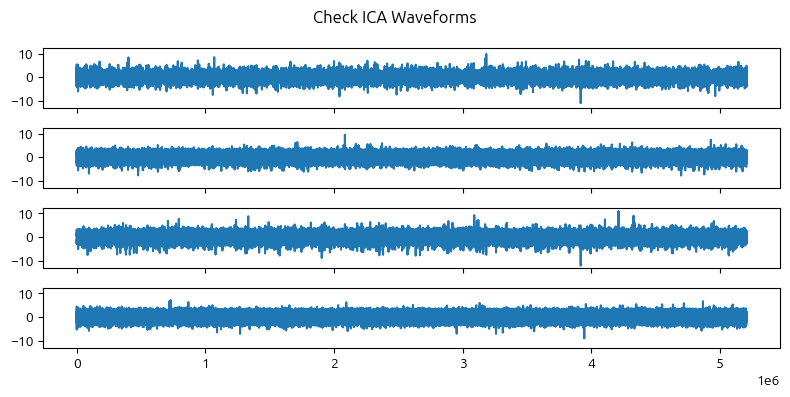

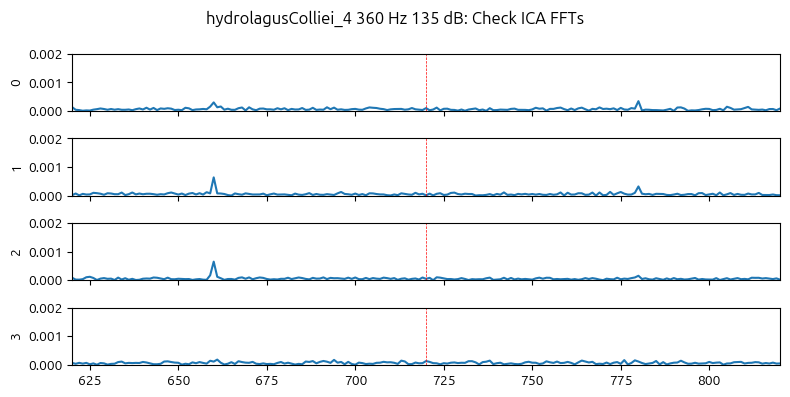

In [1213]:
plot_waveforms(input_data, channel_keys=[], 
               title='Check ICA Waveforms', num_samples=[], figsize=(8, 4), alpha=1.0)
plot_fft(ica_fft_magnitudes, ica_fft_freq_vec, myfreq, myamp, subjid, dataset_index, channel_keys=[], period_keys=[],
         title='Check ICA FFTs', num_samples=5, figsize=(8, 4), alpha=1.0,xlim=[myfreq*2-100,myfreq*2+100], ylim=[0,0.002])


In [1214]:
ica_doub_freq = select_doub_freq_bin(ica_fft_magnitudes, ica_fft_freq_vec, [], myfreq, window_size=100)
weights = create_ICA_weights(ica_doub_freq)
recon_restruct_data = weight_and_reconstruct_ica(ica_results, current_cond, channel_keys, [0,1,2,3], component_weights=None)
weights

(11026,)
[717. 718. 719. 720. 721. 722. 723.]
[670. 671. 672. 673. 674. 675. 676. 677. 678. 679. 680. 681. 682. 683.
 684. 685. 686. 687. 688. 689. 690. 691. 692. 693. 694. 695. 696. 697.
 698. 699. 700. 701. 702. 703. 704. 705. 706. 707. 708. 709. 710. 711.
 712. 713. 714. 715. 716. 717. 718. 719. 720. 721. 722. 723. 724. 725.
 726. 727. 728. 729. 730. 731. 732. 733. 734. 735. 736. 737. 738. 739.
 740. 741. 742. 743. 744. 745. 746. 747. 748. 749. 750. 751. 752. 753.
 754. 755. 756. 757. 758. 759. 760. 761. 762. 763. 764. 765. 766. 767.
 768. 769. 770.]
[670. 671. 672. 673. 674. 675. 676. 677. 678. 679. 680. 681. 682. 683.
 684. 685. 686. 687. 688. 689. 690. 691. 692. 693. 694. 695. 696. 697.
 698. 699. 700. 701. 702. 703. 704. 705. 706. 707. 708. 709. 710. 711.
 712. 713. 714. 715. 716. 724. 725. 726. 727. 728. 729. 730. 731. 732.
 733. 734. 735. 736. 737. 738. 739. 740. 741. 742. 743. 744. 745. 746.
 747. 748. 749. 750. 751. 752. 753. 754. 755. 756. 757. 758. 759. 760.
 761. 762. 763

array([0.22874331, 0.25031136, 0.26069349, 0.26025184])

### Save weights to csv

In [1215]:
weights_df = pd.DataFrame({
    'subjid': [subjid] * len(weights),
    'freq': [myfreq] * len(weights),
    'amp': [myamp] * len(weights),
    'channel': channel_keys,
    'weight': weights
})

# Save to CSV
weights_df.to_csv(f'weights_csv/{subjid}/{subjid}_{myfreq}Hz_{myamp}dB_weights_{dataset_index}.csv', index=False)

### Compare denoised signal to original signal

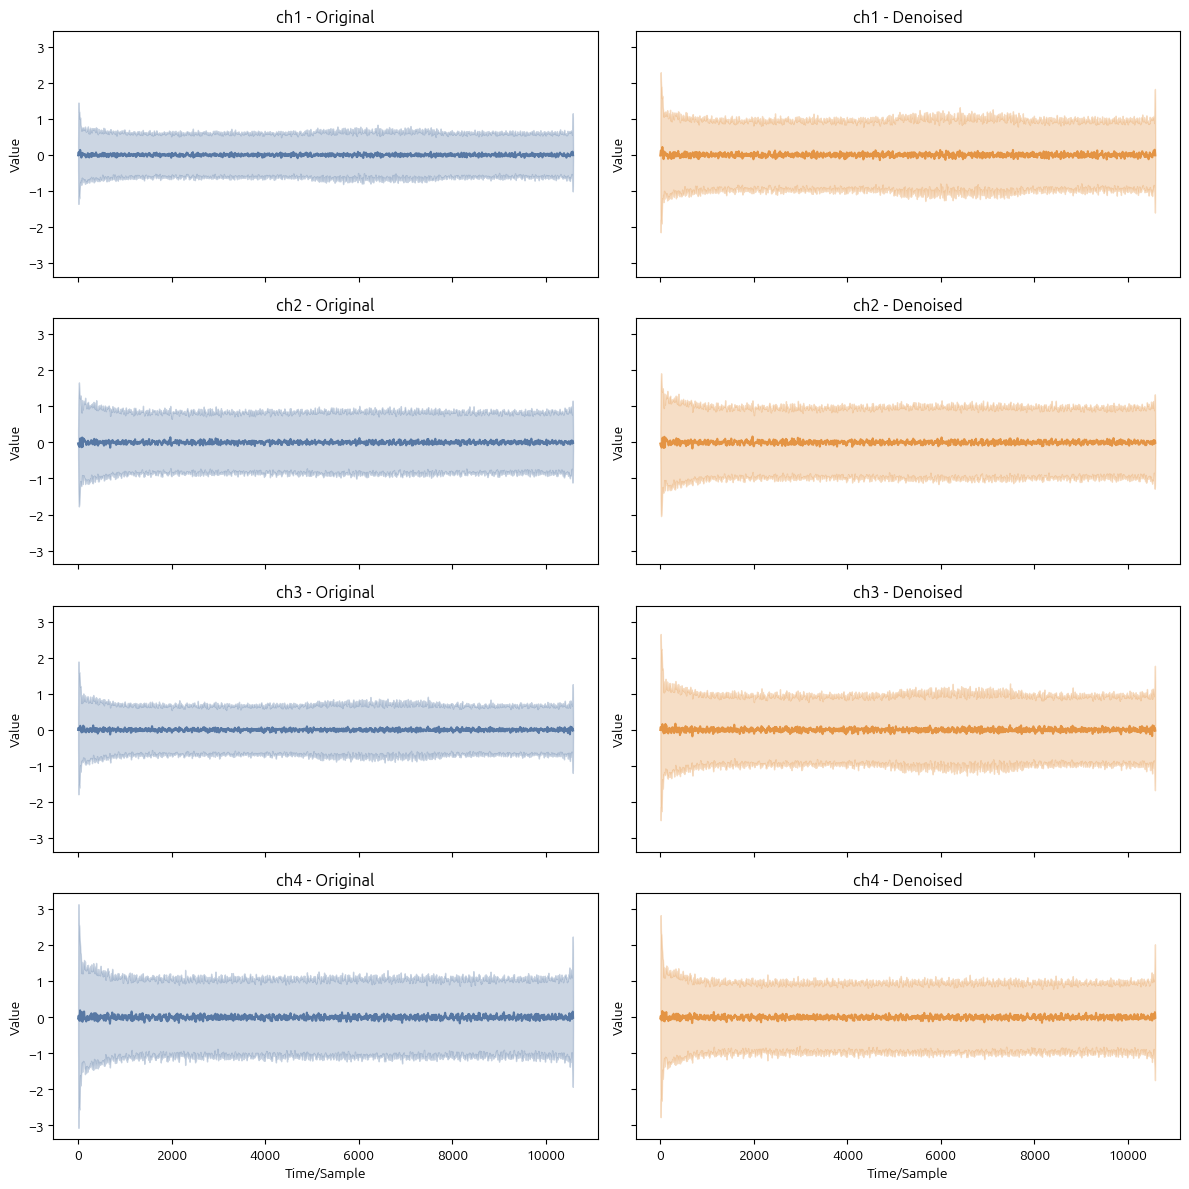

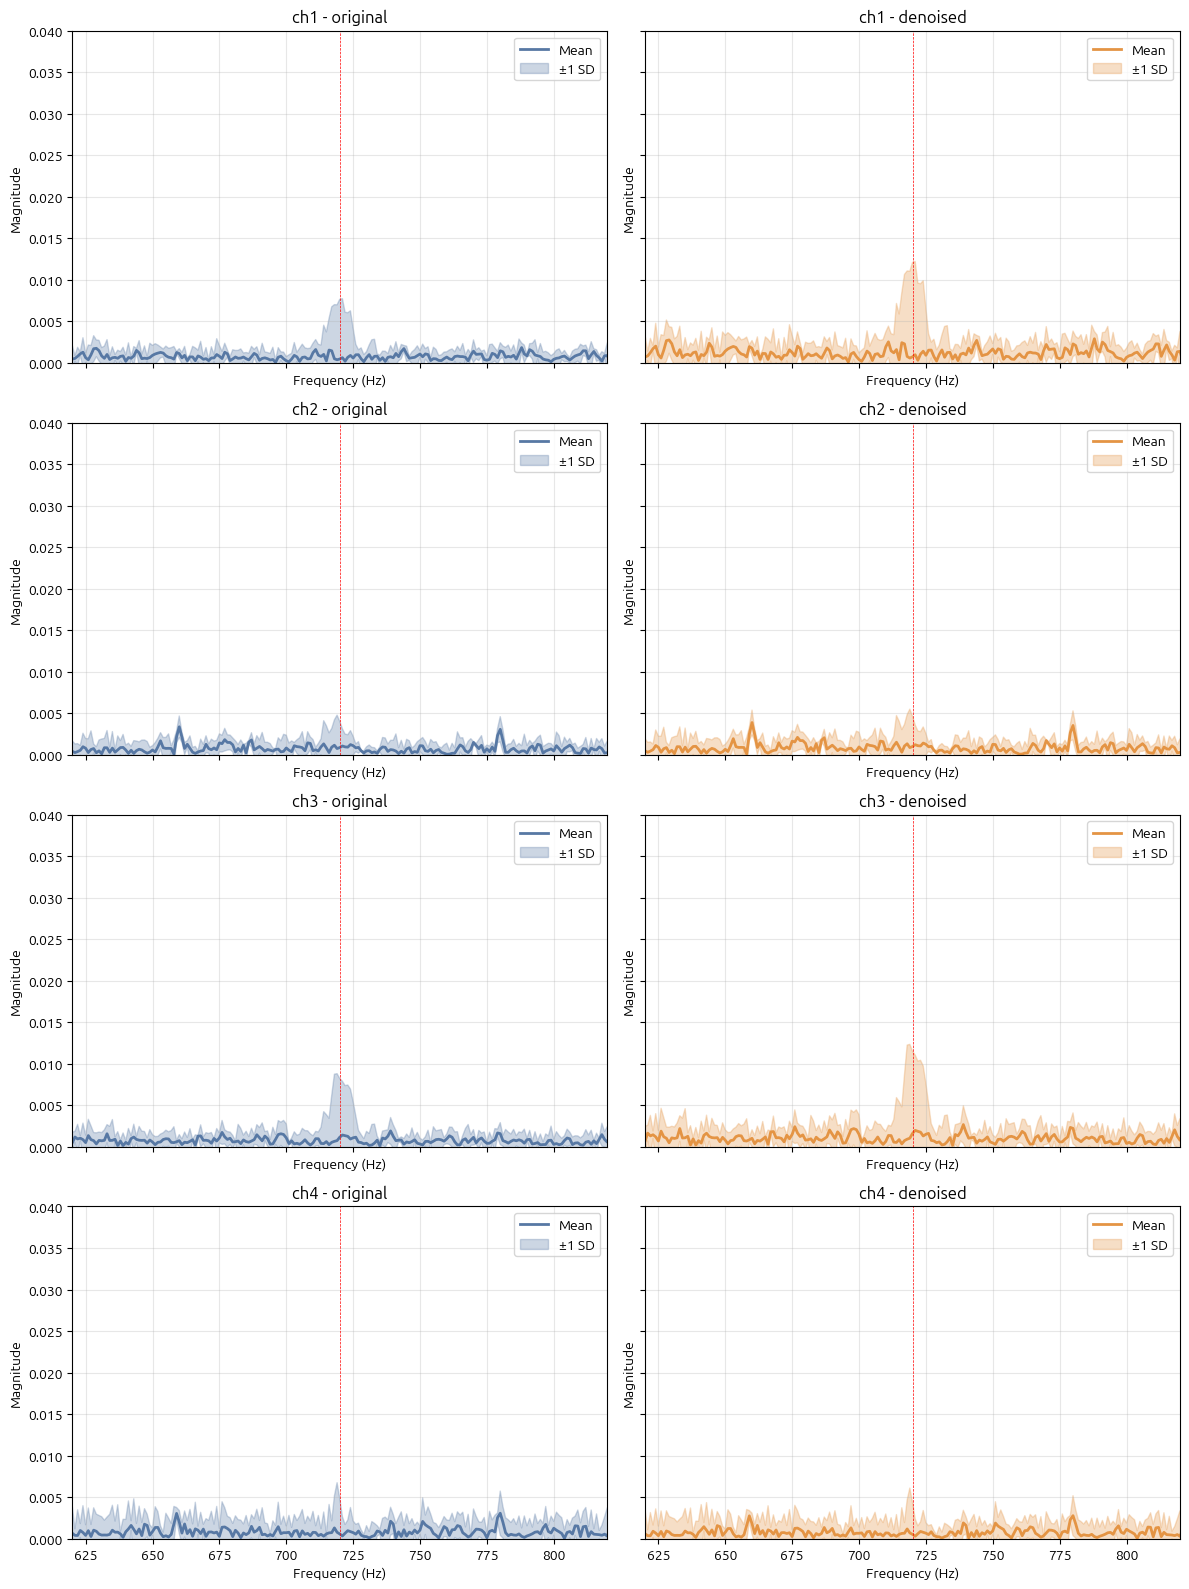

In [1216]:
compare_denoising_mean, compare_denoising_std, fft_magnitudes_mean, fft_magnitudes_std, fft_freq_vecs = compare_denoised_waveform(
                          filt_data, recon_restruct_data, 
                          channel_keys, myfreq, 
                          myamp, subjid, fs, dataset_index,
                          fft_ylim=[0, 0.04])

### Add weights to time domain trials

In [1217]:
# weights = [0.25,0.25,0.25,0.25]
# weighted_data = add_weights(current_cond, channel_keys, weights)

### Separate denoised data

(<Figure size 800x400 with 8 Axes>,
 array([[<Axes: ylabel='ch1'>, <Axes: ylabel='ch1'>],
        [<Axes: ylabel='ch2'>, <Axes: ylabel='ch2'>],
        [<Axes: ylabel='ch3'>, <Axes: ylabel='ch3'>],
        [<Axes: ylabel='ch4'>, <Axes: ylabel='ch4'>]], dtype=object))

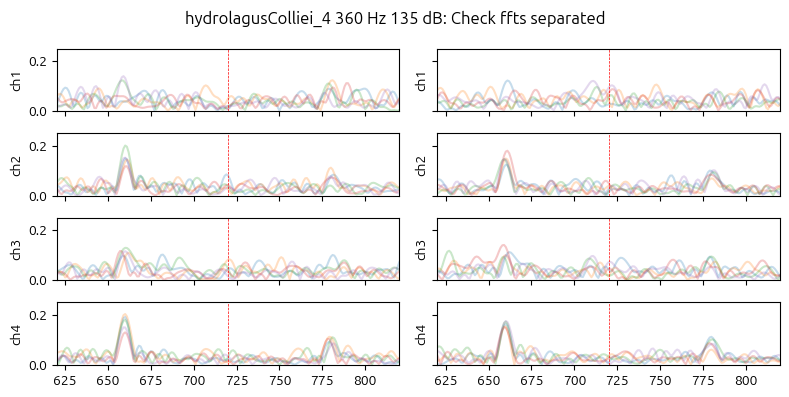

In [1218]:
separated_data = separate_periods(recon_restruct_data, current_cond, period_keys, channel_keys, latency)
weighted_ffts, weighted_freq_vec = compute_fft(separated_data, channel_keys, period_keys, smallest_dim=[], fs=fs)
plot_fft(weighted_ffts, weighted_freq_vec, myfreq, myamp, subjid, dataset_index, channel_keys,
            period_keys=period_keys, 
            title='Check ffts separated', 
            num_samples=5, 
            figsize=(8, 4), 
            alpha=0.25,
            xlim=[myfreq*2-100,myfreq*2+100],
            ylim=[0,0.25]
)

In [1219]:
collapsed_dict = collapse_channels(weighted_ffts, period_keys, channel_keys)
bootstrap_means, bootstrap_stds = calculate_bootstrap(
    collapsed_dict, period_keys, channel_keys,
    n_iterations=100)


1968


### Calculate comparison of grand averages between periods

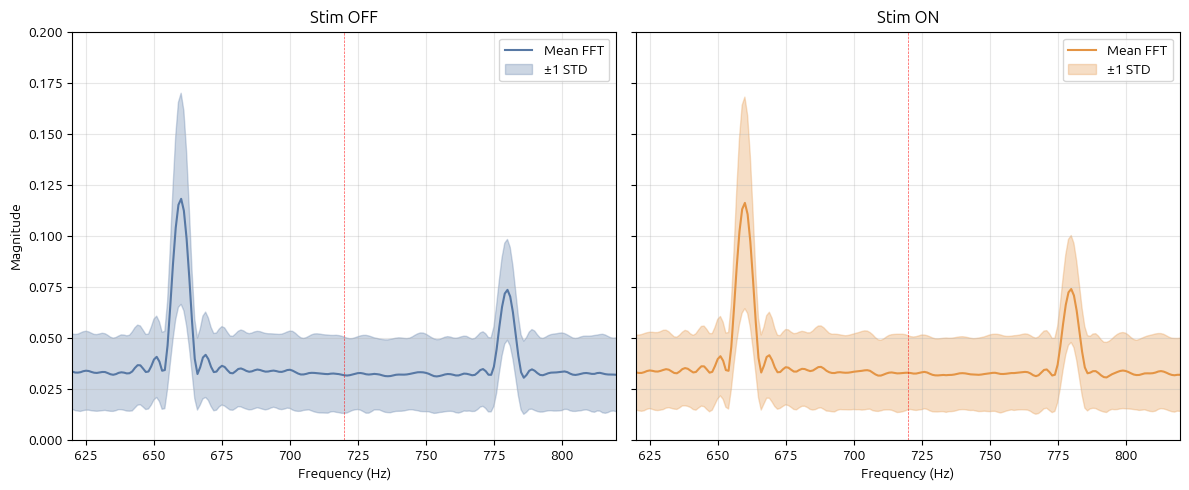

In [1220]:
current_avg = 3
mean_fft_prestim = bootstrap_means['prestim'][current_avg]
std_fft_prestim = bootstrap_stds['prestim'][current_avg]

mean_fft_stimresp = bootstrap_means['stimresp'][current_avg]
std_fft_stimresp = bootstrap_stds['stimresp'][current_avg]

freq_vec = weighted_freq_vec['prestim']['ch1'][current_avg]

plot_bootstrap_fft_comparison(mean_fft_prestim, std_fft_prestim, 
                        mean_fft_stimresp, std_fft_stimresp, 
                        freq_vec, myfreq, myamp, subjid, dataset_index,
                        xlim=[myfreq*2-100,myfreq*2+100], ylim=[0.0,0.2],
                        save_fig=True, save_path=None)


### Calculate bootstrapped SNR by period

In [1221]:
doub_freq_dict = select_doub_freq_bin(bootstrap_means, weighted_freq_vec, period_keys, myfreq, window_size=100)

(492, 11026)
[717. 718. 719. 720. 721. 722. 723.]
(11026,)
[670. 671. 672. 673. 674. 675. 676. 677. 678. 679. 680. 681. 682. 683.
 684. 685. 686. 687. 688. 689. 690. 691. 692. 693. 694. 695. 696. 697.
 698. 699. 700. 701. 702. 703. 704. 705. 706. 707. 708. 709. 710. 711.
 712. 713. 714. 715. 716. 724. 725. 726. 727. 728. 729. 730. 731. 732.
 733. 734. 735. 736. 737. 738. 739. 740. 741. 742. 743. 744. 745. 746.
 747. 748. 749. 750. 751. 752. 753. 754. 755. 756. 757. 758. 759. 760.
 761. 762. 763. 764. 765. 766. 767. 768. 769. 770.]
100


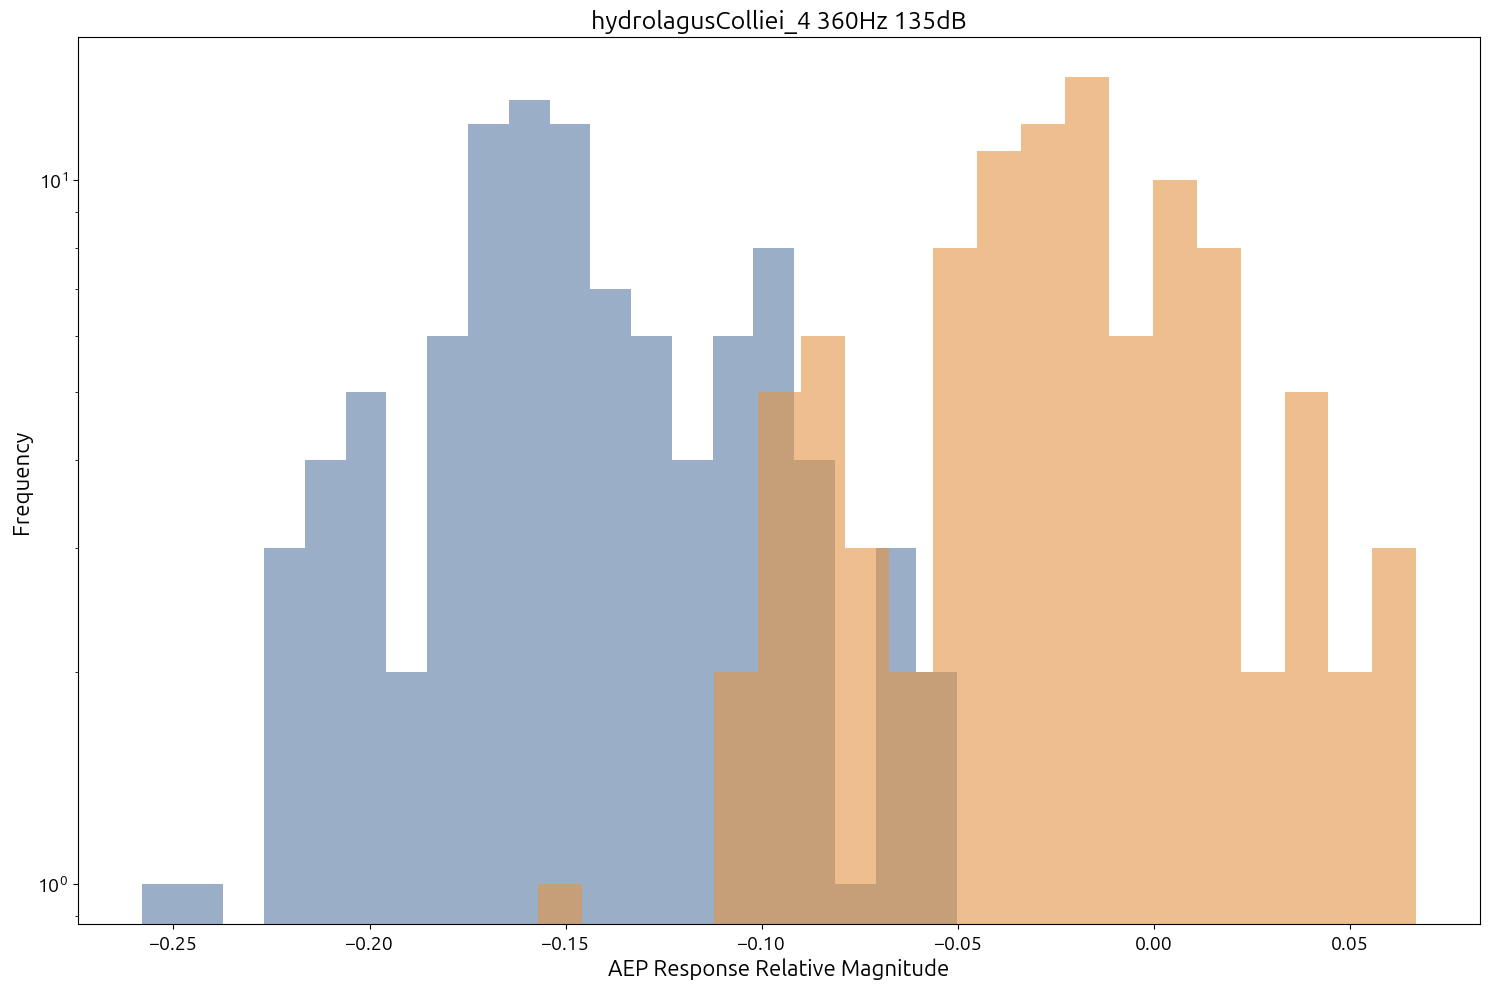

In [1222]:
plot_doub_freq_hist(doub_freq_dict, subjid, 'SNR', myfreq, myamp, 20, dataset_index)

In [1223]:
diff_CI_results = calculate_diff_CI(doub_freq_dict, 'SNR')

# Save
ci_df = pd.DataFrame({
    'subjid': [subjid],
    'freq': [myfreq],
    'amp': [myamp],
    'lower_CI': [diff_CI_results[0]],
    'upper_CI': [diff_CI_results[1]]
})

# Save to CSV
ci_df.to_csv(f'CI_csv/{subjid}/{subjid}_{myfreq}Hz_{myamp}dB_CI_{dataset_index}.csv', index=False)


95% CI: (0.016267062444933672, 0.22256565213801524)
Groups differ significantly (CI excludes 0).


### Save results

In [1224]:
# save_data = {
#     'subjid': subjid, 'fs': fs, 'latency': latency, 'channel_keys': channel_keys,
#     'period_keys': period_keys, 'metric_keys': metric_keys, 'submetric_keys': submetric_keys,
#     'freq_amp_table_df': freq_amp_table_df, 'myfreq': myfreq, 'myamp': myamp,
#     'low': low, 'high': high, 'filt_data': filt_data, 'input_data': input_data,
#     'ica_fft_magnitudes': ica_fft_magnitudes, 'ica_fft_freq_vec': ica_fft_freq_vec,
#     'ica_doub_freq': ica_doub_freq, 'weights': weights, 'recon_restruct_data': recon_restruct_data,
#     'compare_denoising_mean': compare_denoising_mean, 'compare_denoising_std': compare_denoising_std,
#     'fft_magnitudes_mean': fft_magnitudes_mean, 'fft_magnitudes_std': fft_magnitudes_std,
#     'fft_freq_vecs': fft_freq_vecs, 'weighted_ffts': weighted_ffts,
#     'weighted_freq_vec': weighted_freq_vec, 'mean_fft_prestim': mean_fft_prestim,
#     'std_fft_prestim': std_fft_prestim, 'mean_fft_stimresp': mean_fft_stimresp,
#     'std_fft_stimresp': std_fft_stimresp, 'freq_vec': freq_vec,
#     'doub_freq_dict': doub_freq_dict, 'diff_CI_results': diff_CI_results
# }
# with open(f'{subjid}_{myfreq}Hz_{myamp}dB.pkl', 'wb') as f:
#     pickle.dump(save_data, f)

### Play sound to let me know I am done!

In [1225]:
# # To load them back:
# data = load_variables('my_analysis.pkl')
# subjid = data['subjid']
# fs = data['fs']
# # ... etc for all variables

### Notes

In [1226]:
# Denoise/Make best use of all channels
# by applying weights to each channel based on how stable their mean estimate of
# the double frequency response

# Artefact rejection

# Step 1: Add weights to per trial time domain signals by channel 
# Step 2: Conduct ffts on per trial basis on the weighted trials as one mega-channel
# Step 3: In FFT land, calculate the difference between stim and prestim on trial by trial basis
# Step 4: Take the mean on the differences
# Step 5: Calculate the standard deviation as well (optimize around reducing S as much as possible)
# Step 6: Calculate ICA

# After determining weights and performing ICA based denoising...
# Step 6: Bootstrap: Take the data generated from step 2, conduct bootstrap averaging per period, create a distribution of estimates of SNR for each period
# Step 7: 95% CI of the differences between prestim and stimresp
